# Task #1
Perform sentiment analysis on the Amazon mobile reviews from the `/content/Amazon_Unlocked_Mobile.csv` dataset by:
1. Tokenizing the cleaned reviews.
2. Training a Word2Vec model on the tokenized reviews.
3. Generating review embeddings by averaging the word vectors.
4. Preparing sentiment labels from the 'Rating' column (e.g., ratings 4 and 5 as positive, 1 and 2 and 3 as negative).
5. Splitting the embeddings and labels into training and testing sets.
6. Training a machine learning classifier on the generated embeddings and sentiment labels.
7. Evaluating the classifier's performance using relevant metrics.

In [1]:
!pip install --upgrade gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
from gensim.models import Word2Vec


In [3]:
df=pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5.0,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4.0,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5.0,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4.0,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4.0,Great phone to replace my lost phone. The only...,0.0


In [4]:
reviews_series = df['Reviews']
print("Shape of 'Reviews' before dropping duplicates:", reviews_series.shape)

reviews_unique = reviews_series.drop_duplicates()
print("Shape of 'Reviews' after dropping duplicates:", reviews_unique.shape)

Shape of 'Reviews' before dropping duplicates: (102620,)
Shape of 'Reviews' after dropping duplicates: (32324,)


Here's an explanation of the regular expression used to clean the reviews:

1.  **`https?://\S+`**: Matches URLs starting with `http://` or `https://`.
2.  **`www\.\S+`**: Matches URLs starting with `www.`.
3.  **`[@#]\S+`**: Matches mentions (e.g., `@username`) and hashtags (e.g., `#hashtag`).
4.  **`\d{1,2}:\d{2}(?::\d{2})?(?:\s*[apAP][mM])?`**: Matches time formats like `HH:MM`, `HH:MM:SS`, and `HH:MM AM/PM`.

In [5]:
import re

# Define a regex pattern to match links, mentions, hashtags, and time formats
pattern = r'https?://\S+|www\.\S+|[@#]\S+|\d{1,2}:\d{2}(?::\d{2})?(?:\s*[apAP][mM])?'

# Apply the regex replacement to the unique reviews
reviews_cleaned = reviews_unique.astype(str).str.replace(pattern, '', regex=True)

print("Original first 5 unique reviews (after dropping duplicates):")
print(reviews_unique.head())
print("\nFirst 5 cleaned reviews:")
print(reviews_cleaned.head())

Original first 5 unique reviews (after dropping duplicates):
0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
Name: Reviews, dtype: object

First 5 cleaned reviews:
0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
Name: Reviews, dtype: object


In [6]:
reviews_cleaned_df = pd.DataFrame(reviews_cleaned)
reviews_cleaned_df.columns = ['Cleaned Reviews']

print("Shape of 'reviews_cleaned_df':", reviews_cleaned_df.shape)
print("\nFirst 5 rows of 'reviews_cleaned_df':")
display(reviews_cleaned_df.head())

Shape of 'reviews_cleaned_df': (32324, 1)

First 5 rows of 'reviews_cleaned_df':


,Cleaned Reviews
0,I feel so LUCKY to have found this used (phone...
1,"nice phone, nice up grade from my pantach revu..."
2,Very pleased
3,It works good but it goes slow sometimes but i...
4,Great phone to replace my lost phone. The only...


## Train Word2Vec Model

### Subtask:
Train the Word2Vec model using the `tokenized_reviews`. This will create vector representations for individual words.


In [7]:
from gensim.models import Word2Vec
tokenized_reviews = reviews_cleaned.apply(lambda x: x.split())
print("First 5 tokenized reviews:")
print(tokenized_reviews.head())

# Initialize and train the Word2Vec model
model = Word2Vec(sentences=tokenized_reviews, vector_size=50, window=3, min_count=1, sg=0)
print("Word2Vec model trained successfully.")
print(f"Model vocabulary size: {len(model.wv.index_to_key)}")

First 5 tokenized reviews:
0    [I, feel, so, LUCKY, to, have, found, this, us...
1    [nice, phone,, nice, up, grade, from, my, pant...
2                                      [Very, pleased]
3    [It, works, good, but, it, goes, slow, sometim...
4    [Great, phone, to, replace, my, lost, phone., ...
Name: Reviews, dtype: object
Word2Vec model trained successfully.
Model vocabulary size: 69704


## Generate Review Embeddings

### Subtask:
Create a function to average the word vectors for each review. This will transform each review into a fixed-size vector, suitable for a classifier.


**Reasoning**:
The subtask requires generating review embeddings by applying the previously defined `get_sentence_embedding` function to each cleaned review and then converting the results into a NumPy array.



In [8]:
import numpy as np
def get_sentence_embedding(sentence, model):
    words = sentence.lower().split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [9]:
review_embeddings = reviews_cleaned.apply(lambda x: get_sentence_embedding(x, model))
review_embeddings_array = np.array(review_embeddings.tolist())

print("Shape of review_embeddings_array:", review_embeddings_array.shape)

Shape of review_embeddings_array: (32324, 50)


## Prepare Sentiment Labels

### Subtask:
Extract sentiment labels from the 'Rating' column of the original DataFrame. For example, ratings 4 and 5 can be positive, 1 and 2 and 3 as negative.


In [10]:
unique_review_ratings = df.loc[reviews_unique.index, 'Rating']

def map_rating_to_sentiment(rating):
    if rating in [4, 5]:
        return 1  # Positive
    elif rating in [1, 2, 3]:
        return 0 # Negative


sentiment_labels = unique_review_ratings.apply(map_rating_to_sentiment)

# Drop any rows where sentiment_labels might be None due to invalid ratings (if any)
sentiment_labels = sentiment_labels.dropna()

print("Sentiment Label Distribution:")
print(sentiment_labels.value_counts())
print(f"\nShape of sentiment_labels: {sentiment_labels.shape}")

Sentiment Label Distribution:
Rating
1    20436
0    11888
Name: count, dtype: int64

Shape of sentiment_labels: (32324,)


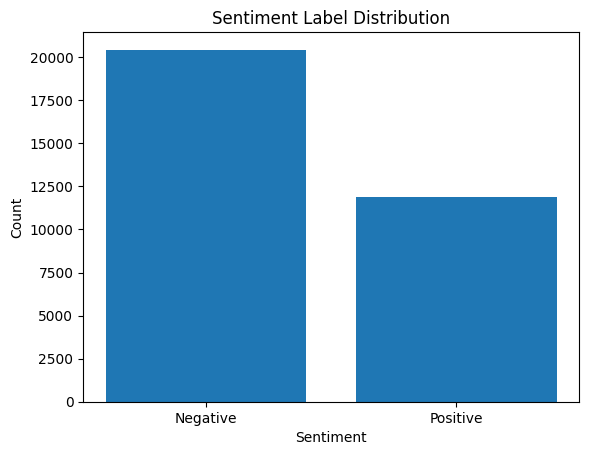

In [15]:
plt.bar(['Negative', 'Positive'], sentiment_labels.value_counts())
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Label Distribution')
plt.show()

## Split Data

### Subtask:
Split the generated review embeddings and corresponding sentiment labels into training and testing sets.


**Reasoning**:
To split the data into training and testing sets as per the instructions, I need to import the `train_test_split` function from `sklearn.model_selection`.



In [11]:
from sklearn.model_selection import train_test_split

# Split the embeddings and sentiment labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    review_embeddings_array,
    sentiment_labels,
    test_size=0.2,
    random_state=42
)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (25859, 50)
Shape of X_test: (6465, 50)
Shape of y_train: (25859,)
Shape of y_test: (6465,)


## Train Sentiment Classifier

### Subtask:
Train a machine learning classifier (e.g., Random Forest  or a simple Neural Network) using the review embeddings as features and the sentiment labels as targets.


**Reasoning**:
To train a machine learning classifier as per the subtask instructions, I will import the `RandomForestClassifier` class, instantiate it with a suitable solver and max_iter, and then train the model using the `X_train` and `y_train` data.



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Train the classifier
model.fit(X_train, y_train)

print("Random Forest Classifier trained successfully.")

Random Forest Classifier trained successfully.


In [13]:
y_preds=model.predict(X_test)
print(f"Model score on testing data:",accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

Model score on testing data: 0.8369682907965971
              precision    recall  f1-score   support

           0       0.80      0.74      0.76      2324
           1       0.86      0.89      0.88      4141

    accuracy                           0.84      6465
   macro avg       0.83      0.81      0.82      6465
weighted avg       0.84      0.84      0.84      6465



# Task #2
Generate review embeddings for the cleaned reviews using the `get_sentence_embedding_glove` function and the `glove_model`.

## Generate Review Embeddings (GloVe)

### Subtask:
Apply the `get_sentence_embedding_glove` function to each cleaned review, using the loaded `glove_model`, to create GloVe-based review embeddings.


**Reasoning**:
To generate GloVe-based review embeddings, I will apply the `get_sentence_embedding_glove` function to each cleaned review, convert the resulting Series to a NumPy array, and then print its shape to verify the dimensions.



In [17]:
import gensim.downloader as api
# Use pre-trained embeddings (GloVe)
print("\n--- Using Pre-trained Embeddings (GloVe) ---")
glove_model = api.load("glove-wiki-gigaword-50")

# Define a function to get sentence embedding using GloVe
def get_sentence_embedding_glove(sentence, model):
    words = sentence.lower().split()
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    if len(word_vectors) == 0:
        return np.zeros(model['data'].shape[0])
    return np.mean(word_vectors, axis=0)




--- Using Pre-trained Embeddings (GloVe) ---
[==================================================] 100.0% 66.0/66.0MB downloaded


In [19]:
review_embeddings_glove = reviews_cleaned.apply(lambda x: get_sentence_embedding_glove(x, glove_model))
review_embeddings_glove_array = np.array(review_embeddings_glove.tolist())

print("Shape of review_embeddings_glove_array:", review_embeddings_glove_array.shape)

Shape of review_embeddings_glove_array: (32324, 50)


## Split Data (GloVe)

### Subtask:
Split the generated GloVe review embeddings and the existing sentiment labels into training and testing sets.


**Reasoning**:
To split the GloVe embeddings and sentiment labels, I will use the `train_test_split` function with the specified parameters and then print the shapes of the resulting datasets for verification.



In [20]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(
    review_embeddings_glove_array,
    sentiment_labels,
    test_size=0.2,
    random_state=42
)

print(f"Shape of X_train_glove: {X_train_glove.shape}")
print(f"Shape of X_test_glove: {X_test_glove.shape}")
print(f"Shape of y_train_glove: {y_train_glove.shape}")
print(f"Shape of y_test_glove: {y_test_glove.shape}")

Shape of X_train_glove: (25859, 50)
Shape of X_test_glove: (6465, 50)
Shape of y_train_glove: (25859,)
Shape of y_test_glove: (6465,)


## Train Sentiment Classifier (GloVe)

### Subtask:
Train a machine learning classifier using the GloVe review embeddings as features and the sentiment labels as targets.

**Reasoning**:
To train a machine learning classifier with the GloVe embeddings, I will use the RandomForestClassifier. I need to instantiate and train the model using the GloVe training data (`X_train_glove`, `y_train_glove`).



In [21]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the RandomForestClassifier for GloVe embeddings
glove_model_classifier = RandomForestClassifier(random_state=42)

# Train the classifier using GloVe training data
glove_model_classifier.fit(X_train_glove, y_train_glove)

print("Random Forest Classifier trained successfully with GloVe embeddings.")

Random Forest Classifier trained successfully with GloVe embeddings.


**Reasoning**:
After training the classifier with GloVe embeddings, the next step is to evaluate its performance on the test set (`X_test_glove`, `y_test_glove`) using relevant metrics like accuracy and a classification report.



In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the GloVe test set
y_pred_glove = glove_model_classifier.predict(X_test_glove)

# Evaluate the model's performance
print(f"Model score on GloVe testing data: {accuracy_score(y_test_glove, y_pred_glove):.4f}")
print("\nClassification Report (GloVe embeddings):\n")
print(classification_report(y_test_glove, y_pred_glove))

Model score on GloVe testing data: 0.8036

Classification Report (GloVe embeddings):

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      2324
           1       0.83      0.88      0.85      4141

    accuracy                           0.80      6465
   macro avg       0.79      0.78      0.78      6465
weighted avg       0.80      0.80      0.80      6465

